## 8. Error Analysis
This notebook is about Error analysis of the Random Forest model we built

In [30]:
## load modules
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from modeling.features import get_feature_combinations
from modeling.functions import predict_func, train_test_split_features, scaler_func
from sklearn.preprocessing import MinMaxScaler
import pickle
sns.set_theme()

In [31]:
# loading the cleaned dataset
data = pd.read_csv('../data/GEFCom2014Data/Wind/clean_data.csv', parse_dates=['TIMESTAMP'], index_col='TIMESTAMP')

In [32]:
# train-test-split 
data_train = data[:'2013-07-01 00:00:00']
data_test = data['2013-07-01 01:00:00':]

In [35]:
# Loading the parameters for every windfarm
df_model = pd.read_csv(f'../results/RandomForestRegressor.csv')

In [36]:
# calculating the residuals
model = RandomForestRegressor()
df_results = pd.DataFrame()

for zone in range(1,11):
    fc = df_model[df_model.ZONE == 'ZONE{}'.format(str(zone))]['FC'].values[0]
    
    data_train_zone = data_train[data_train.ZONEID == zone]
    data_test_zone = data_test[data_test.ZONEID == zone]

    features = get_feature_combinations()[fc]
    X_train, X_test, y_train, y_test = train_test_split_features(data_train, data_test, zone, features)  
    X_train, X_test= scaler_func(X_train, X_test, MinMaxScaler())

    model = pickle.load(open('../models/model{}.pkl'.format(zone), 'rb'))
    y_pred = predict_func(model, X_test, y_test)
    
    tmp_df = data_test_zone.copy() 
    tmp_df['MODEL'] = 'RandomForestRegressor'
    tmp_df['pred'] = y_pred
    tmp_df['RESIDUAL'] = tmp_df.pred - tmp_df.TARGETVAR
    df_results = df_results.append(tmp_df)

Plotting residuals for every Windfarm.

In [37]:
# loading predictions
df_pred = pd.read_csv('../results/RandomForest_Predictions.csv')

# loading observations
df_obs = pd.read_csv('../data/GEFCom2014Data/Wind/clean_data.csv', parse_dates=['TIMESTAMP'])
df_obs = df_obs[df_obs['TIMESTAMP'] >= '2013-07-01 01:00:00']
df_obs = df_obs.reset_index(drop=True)

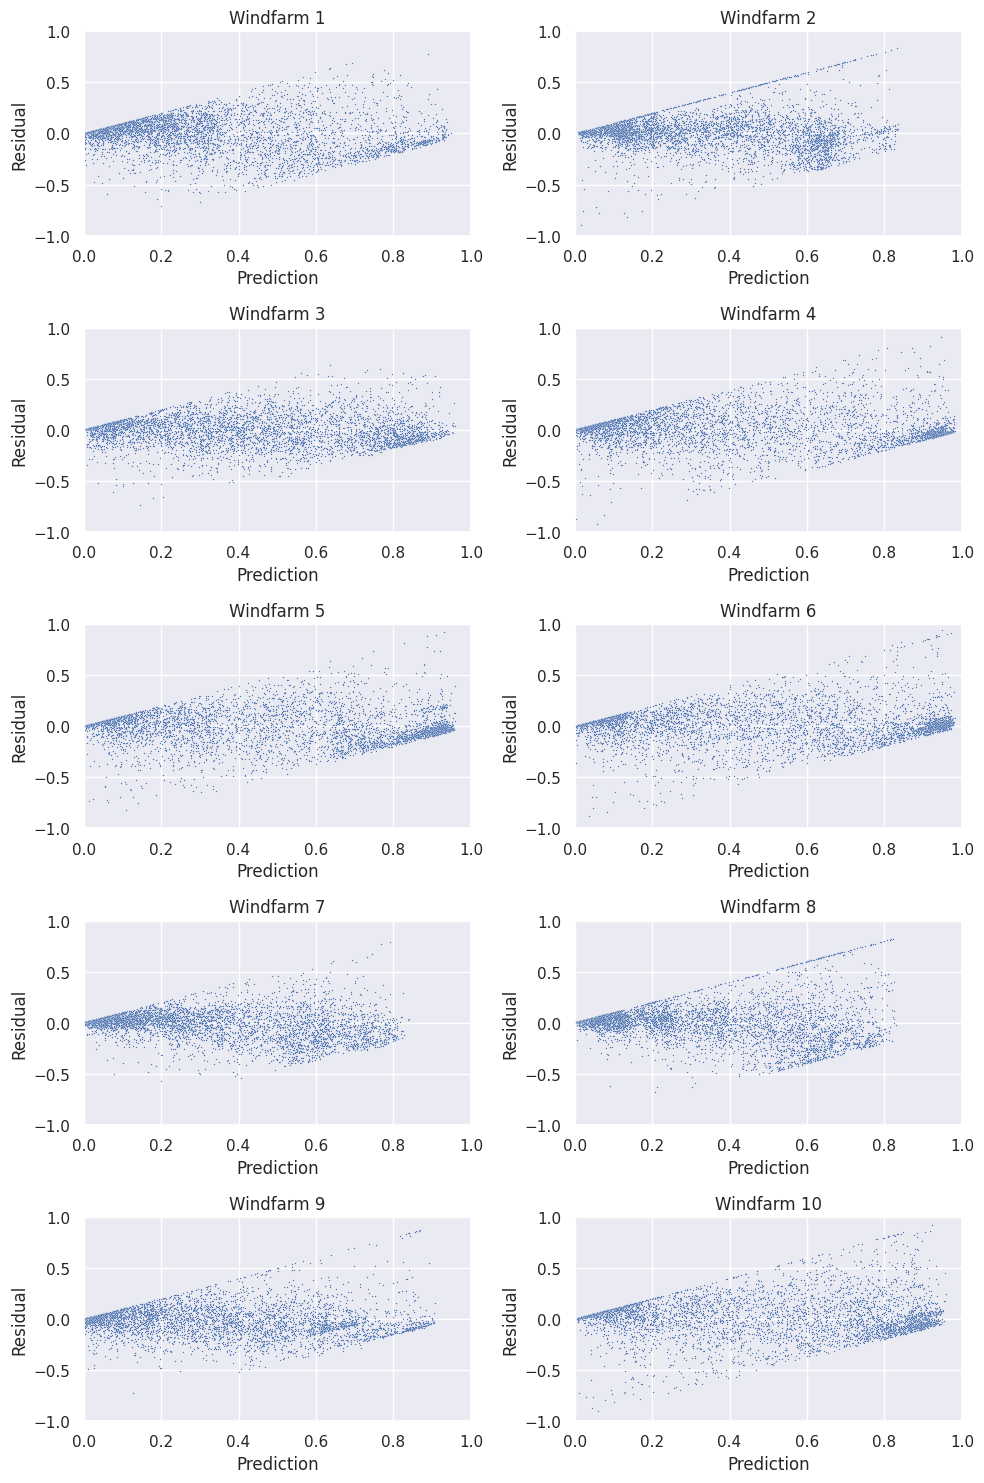

In [38]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10,15), dpi=100)
axs = axs.ravel()

for zone in df_obs.ZONEID.unique():
    ax = axs[zone-1]
    pred = df_pred['Zone {}'.format(str(zone))]
    obs = df_obs[df_obs['ZONEID']==zone].TARGETVAR.values
    p = sns.scatterplot(x = pred, y = pred - obs , s = 1, ax = ax)
    ax.set_title('Windfarm {}'.format(zone))
    ax.set_xlim([0,1])
    ax.set_ylim([-1,1])
    p.set(xlabel = "Prediction", ylabel = "Residual")
fig.tight_layout()     

Plotting residuals aggregated over all wind farms.

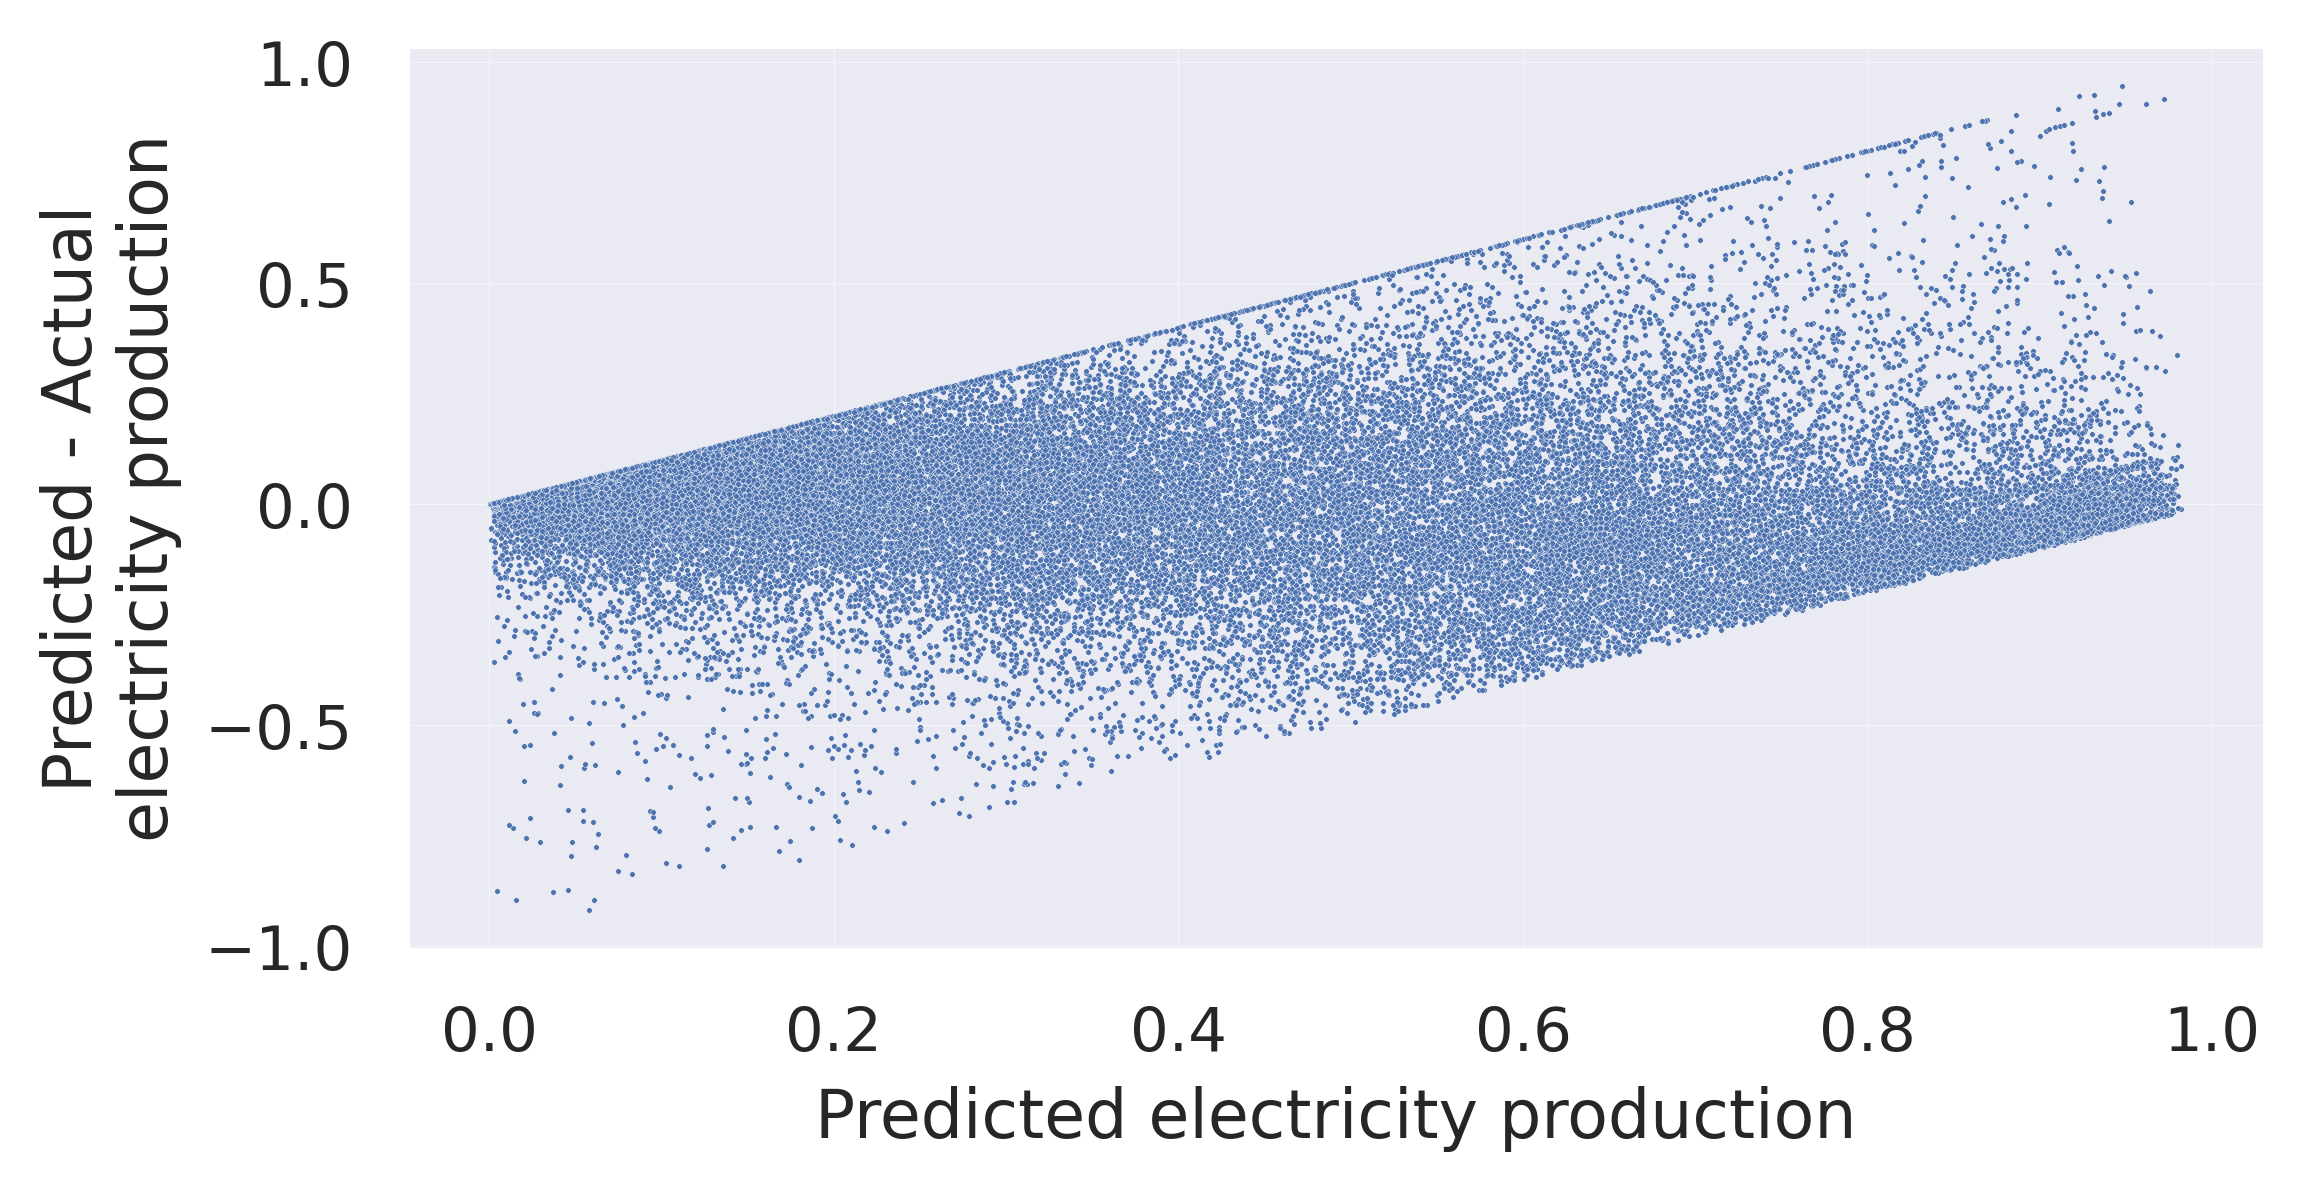

In [39]:
fig,ax = plt.subplots(dpi=400, figsize=(6,3))
scatter = sns.scatterplot(data = df_results, x = 'pred', y = 'RESIDUAL', s=1)
ax.grid(linewidth=.1)
ax.set_ylabel('Predicted - Actual\n electricity production')
ax.set_xlabel('Predicted electricity production');

Plotting averages of residuals.

In [40]:
# Defining bins for predicted wind energy production and predicted wind speed.
pred_bins = [round(x, 2) for x in np.arange(0, 1.01, 0.05)]
pred_labels = []
for i, bin_ in enumerate(pred_bins):
    if i > len(pred_bins) - 2:
        break
    pred_labels.append(f'{bin_:.2f}-{pred_bins[i + 1]:.2f}')

ws_bins = [round(x, 2) for x in np.arange(0, 25, 2)]
ws_labels = []
for i, bin_ in enumerate(ws_bins):
    if i > len(ws_bins) - 2:
        break
    ws_labels.append(f'{bin_}-{ws_bins[i + 1]}')

df_results['PRED_BIN'] = pd.cut(df_results['pred'], bins = pred_bins, labels=pred_labels)
df_results['WS100_BIN'] = pd.cut(df_results['WS100'], bins = ws_bins, labels=ws_labels)

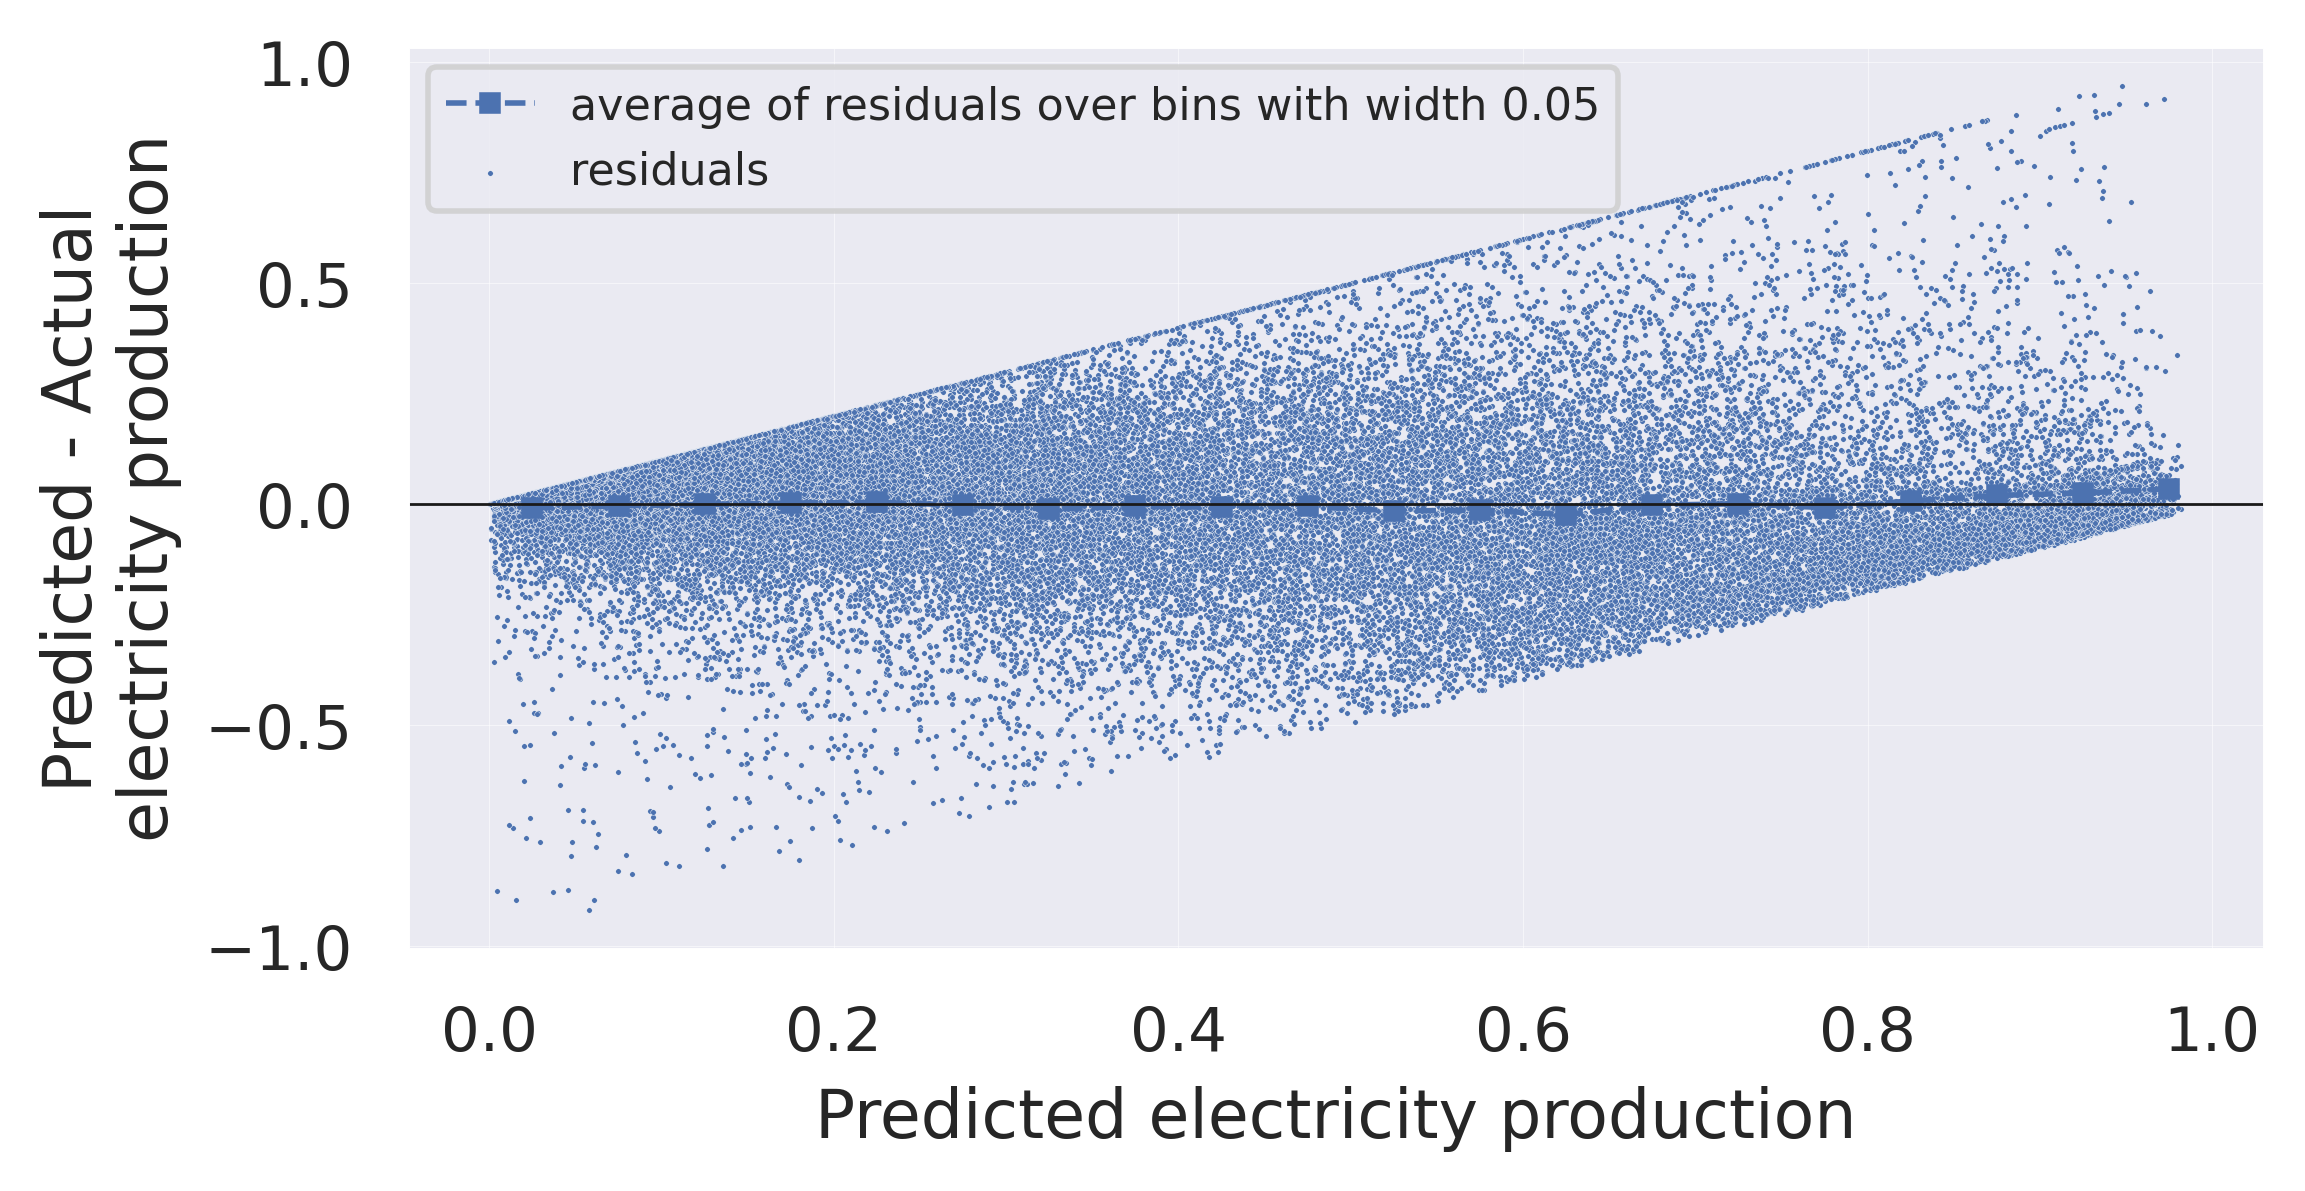

In [41]:
bias = df_results.groupby(by = 'PRED_BIN').mean()['RESIDUAL'] 
fig,ax = plt.subplots(dpi=400, figsize=(6,3))
ax.plot(np.arange(.025,1.00,.05), bias.values, linewidth=1, linestyle='--', 
marker='s', markersize=3, color='b', label='average of residuals over bins with width 0.05')
scatter = sns.scatterplot(data = df_results, x = 'pred', y = 'RESIDUAL', s=1, label='residuals')
ax.grid(linewidth=.1)
ax.set_ylabel('Predicted - Actual\n electricity production')
ax.set_xlabel('Predicted electricity production')
ax.axhline(color = 'k', linewidth = 0.5)
ax.legend(fontsize=8);

Plotting residuals vs predicted windspeed at height 100 m aggregated over all windfarms-

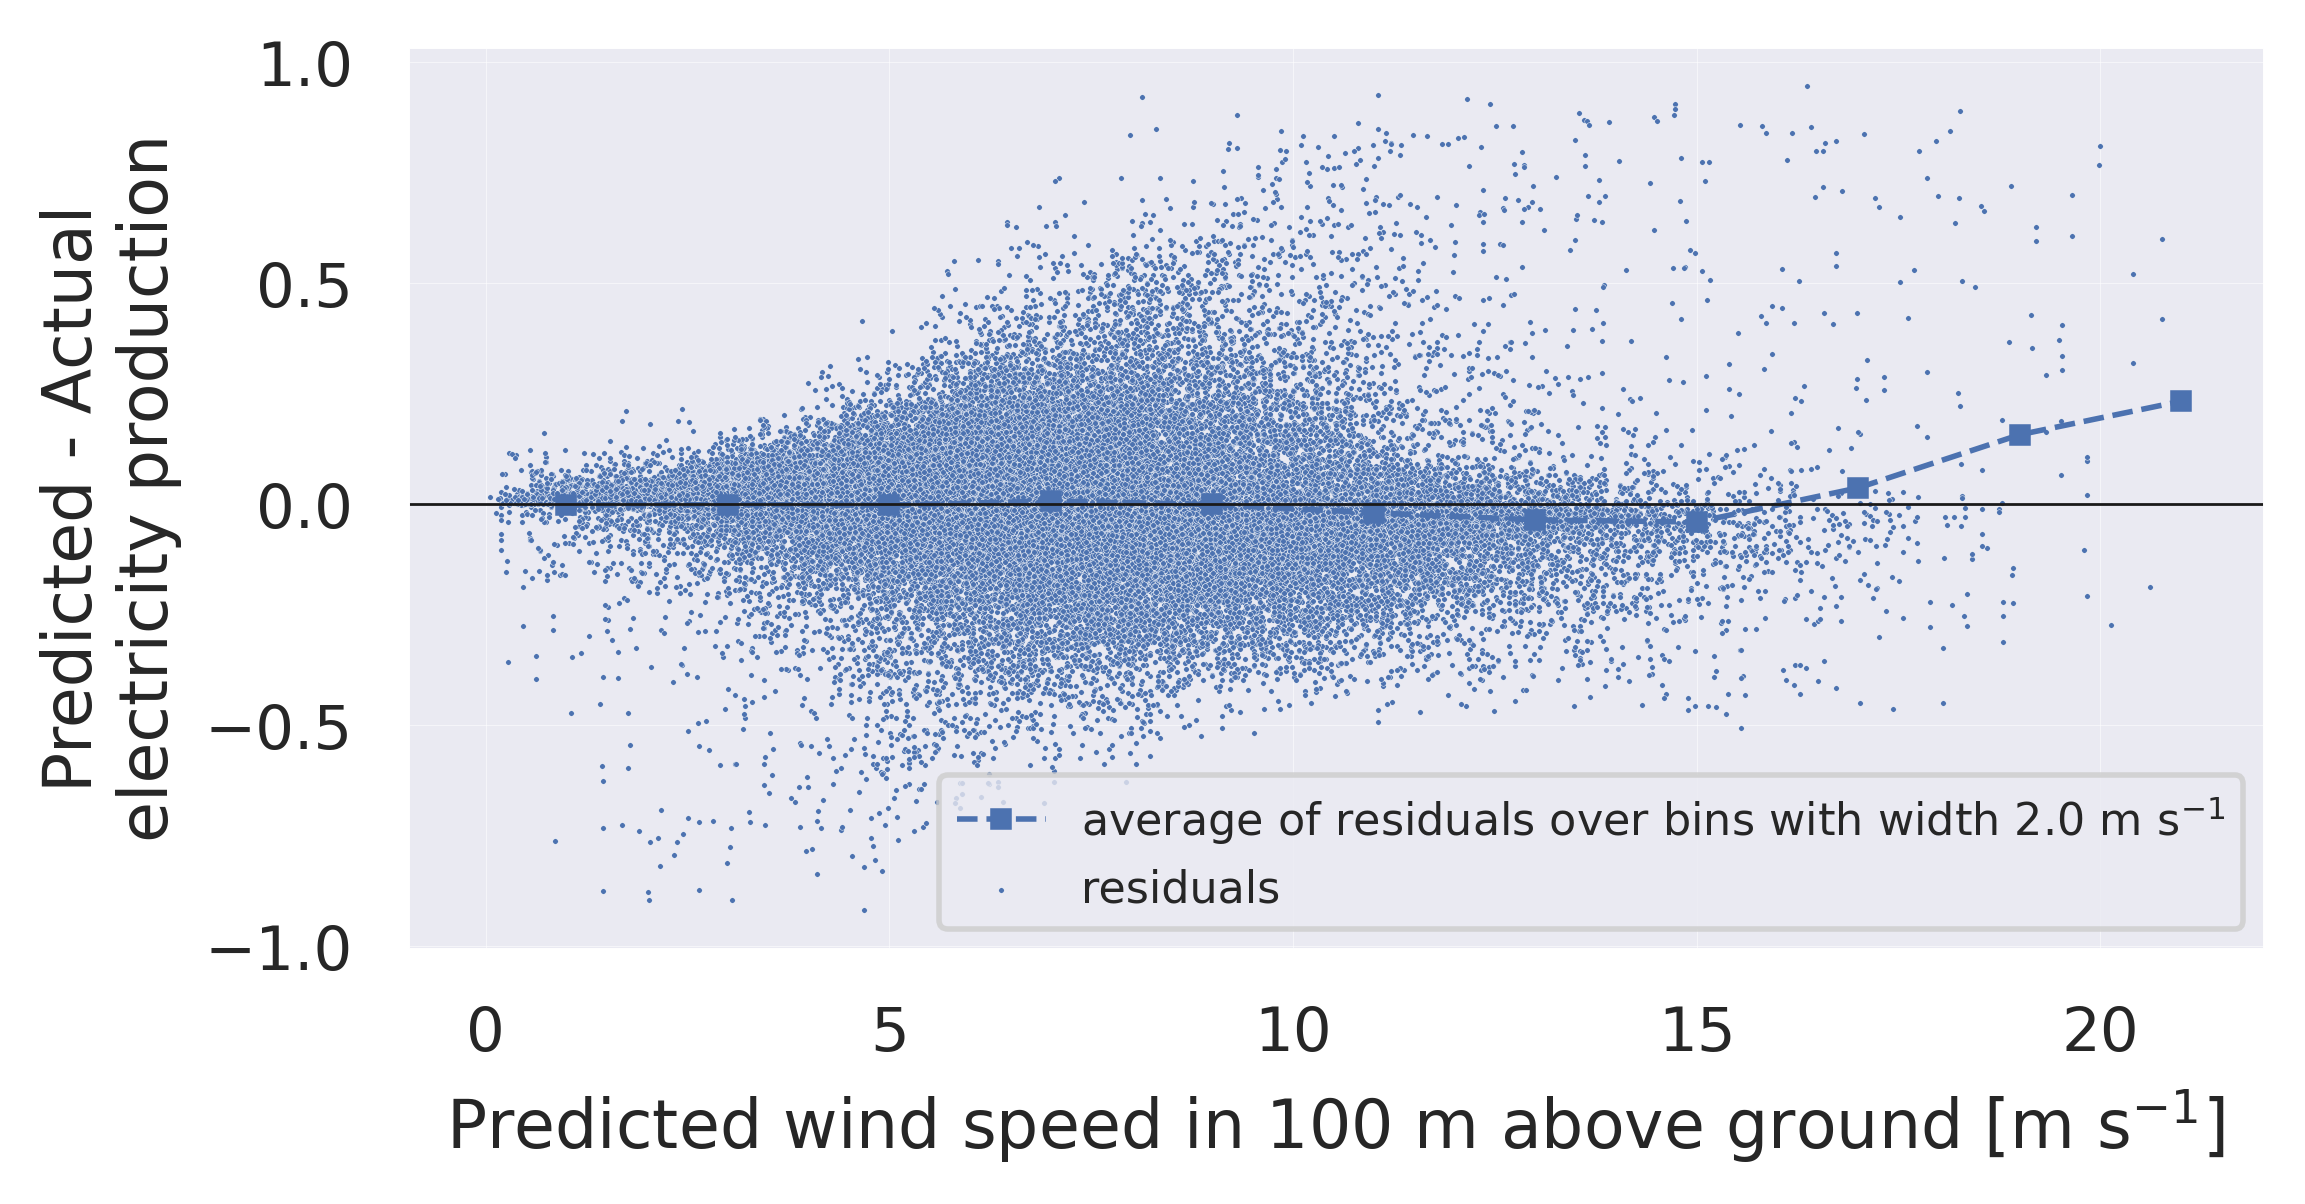

In [42]:
bias = df_results.groupby(by = 'WS100_BIN').mean()['RESIDUAL']
fig,ax = plt.subplots(dpi=400, figsize=(6,3))
ax.plot(np.arange(1,25,2), bias.values, linewidth=1, linestyle='--', marker='s', markersize=3, color='b', 
label='average of residuals over bins with width 2.0 $\mathregular{m\ s^{-1}}$')
scatter = sns.scatterplot(data = df_results, x = 'WS100', y = 'RESIDUAL', s=1, label='residuals')
ax.grid(linewidth=.1)
ax.set_ylabel('Predicted - Actual\n electricity production');
ax.set_xlabel('Predicted wind speed in 100 m above ground [$\mathregular{m\ s^{-1}}$]');
ax.axhline(color = 'k', linewidth = 0.5)
ax.legend(fontsize=8);
fig.savefig('../images/Residuals-By-PredWS100_RandomForest_Aggregated.png')


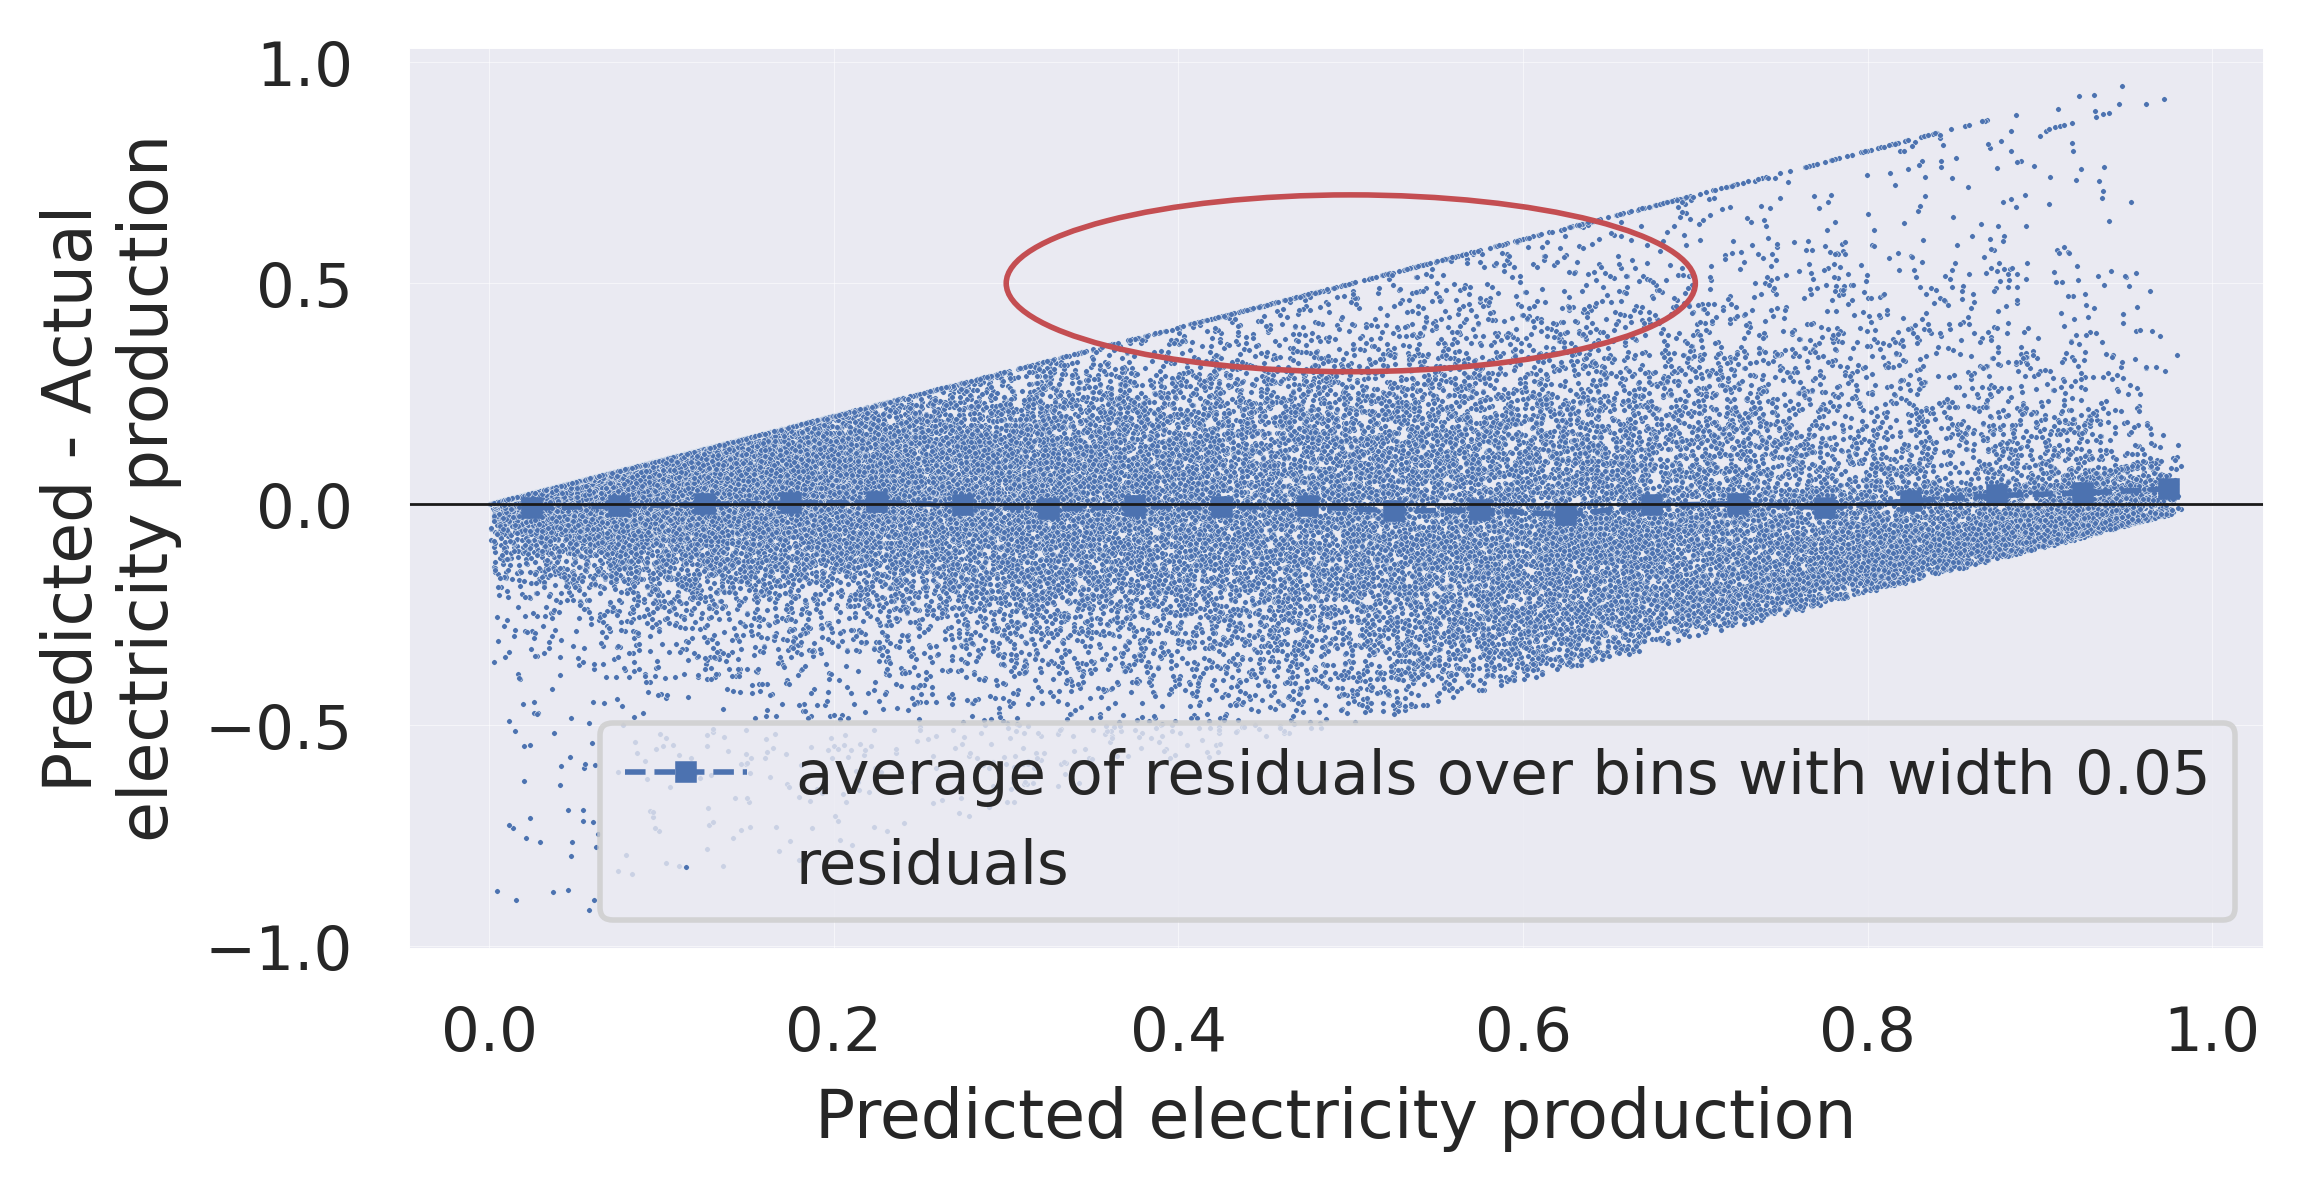

In [43]:
bias = df_results.groupby(by = 'PRED_BIN').mean()['RESIDUAL'] 
fig,ax = plt.subplots(dpi=400, figsize=(6,3))
ax.plot(np.arange(.025,1.00,.05), bias.values, linewidth=1, linestyle='--', marker='s', markersize=3, color='b', label='average of residuals over bins with width 0.05')
scatter = sns.scatterplot(data = df_results, x = 'pred', y = 'RESIDUAL', s=1, label='residuals')
ax.grid(linewidth=.1)
ax.set_ylabel('Predicted - Actual\n electricity production')
ax.set_xlabel('Predicted electricity production')
ax.axhline(color = 'k', linewidth = 0.5)
circle1 = plt.Circle((.5, .5), 0.2, color='r', fill=False)
scatter.add_patch(circle1);

The plot of the residuals look good. The residuals are randomly distributed. <br>
The model performs really well, except: <br>
- the prediction of the zero values, as expected, needs improvement, see the 
last plot
- at higher windspeeds, higher than 15 m/s, the residuals increase<br>  
